In [1]:
from dataset import AirQualityDataset
from dataset.raw_data import air_quality_test_data, air_quality_train_data
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

/home/hoang/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("/home/hoang/Documents/CodeSpace/air-quality-forecasting/data/data-train/input/S0000137-Ngoc Khanh.csv")

In [3]:
df.isna().sum()

Unnamed: 0       0
timestamp        0
PM2.5          897
humidity       681
temperature    681
dtype: int64

In [4]:
eframe_size = 24 * 7
dframe_size = 24

def validate_frame(x: pd.Series):
    if x.isna().sum() == len(x):
        return 0
    return 1

l = 368
mask = []
for i in range(l):
    enc_start = i * dframe_size
    enc_end = enc_start + eframe_size
    dec_start = enc_end
    dec_end = dec_start + dframe_size

    mask.append([
        validate_frame(df["PM2.5"][enc_start : enc_end]),
        validate_frame(df["temperature"][enc_start : enc_end]),
        validate_frame(df["humidity"][enc_start : enc_end]),
    ])

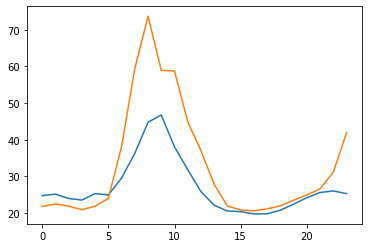

In [5]:
def get_slice(idx):
    start = idx * 24
    return slice(start, start + 24)

i = 7
plt.plot(df["PM2.5"][get_slice(i)].tolist())
plt.plot(df["PM2.5"][get_slice(i + 1)].tolist())

In [6]:
k = df["PM2.5"][7*24:8*24].copy()

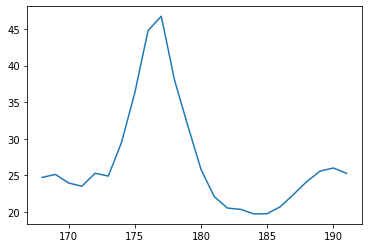

In [7]:
plt.plot(k)

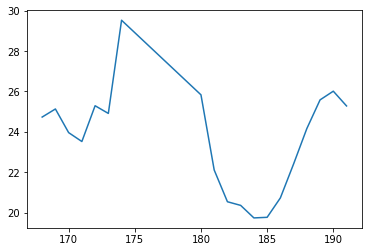

In [8]:
k[7:12] = float("nan")
plt.plot(k.interpolate(option="linear"))

In [30]:
dts = AirQualityDataset(
        "../data",
        normalize_mean={"humidity":0, "temperature": 0, "PM2.5": 0},
        normalize_std={"humidity": 1, "temperature": 1, "PM2.5": 1},
        data_set="train",
        fillnan_fn=lambda x: x.interpolate(option="spline").bfill()
    )

In [34]:
dt = dts[4]

In [36]:
dt["src_locs"][0]

tensor([105.8505,  21.0269])

In [35]:
dt["features"][0]

tensor([[63.1400, 31.2800, 33.1500,  ..., -1.0000,  0.9032,  0.4167],
        [64.7300, 31.1000, 31.7000,  ..., -0.9659,  0.9032,  0.4167],
        [63.0600, 31.5600, 36.2300,  ..., -0.8660,  0.9032,  0.4167],
        ...,
        [73.5700, 31.1900, 23.8300,  ..., -0.7071,  0.1290,  0.5000],
        [73.5700, 31.1900, 23.8300,  ..., -0.8660,  0.1290,  0.5000],
        [73.5700, 31.1900, 23.8300,  ..., -0.9659,  0.1290,  0.5000]])

In [13]:
dt["gt_target"]

KeyError: 'gt_target'

In [ ]:
raw = air_quality_train_data("../data/data-train/")

In [ ]:
from statistics import mean
m, s = [], []

for name, station in raw["input"].items():
    m.append(station["data"]["humidity"].dropna().mean())
    s.append(station["data"]["humidity"].dropna().std())

{
    "mean": mean(m),
    "std": mean(s)
}

{'mean': 75.83080892930954, 'std': 14.527020139735658}

In [ ]:
import torch
x = torch.rand((2, 3))
mask = torch.tensor([[1, 0, 1], [0 ,1, 1]])

In [ ]:
x[:, [0, 2]]

tensor([[0.7820, 0.8237],
        [0.9907, 0.3505]])

In [ ]:
x

tensor([[0.7820, 0.5362, 0.8237],
        [0.9907, 0.7977, 0.3505]])